In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""    
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        """
        Initialize the RNN model.

        Args:
            num_inputs (int): Number of input features.
            num_hiddens (int): Number of hidden units.
            sigma (float): Standard deviation for initializing weights. Default is 0.01.
        """
        super().__init__()
        # Save hyperparameters for later use
        self.save_hyperparameters()
        # Initialize the input-to-hidden weight matrix with random values
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        # Initialize the hidden-to-hidden weight matrix with random values
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        # Initialize the hidden bias vector with zeros
        self.b_h = nn.Parameter(torch.zeros(num_hiddens)) #@save

        
    def forward(self, inputs, state=None):
        """
        Forward propagation of RNN model.

        Args:
            inputs (torch.Tensor): Input data with shape (num_steps, batch_size, num_inputs).
            state (torch.Tensor): Hidden state with shape (batch_size, num_hiddens). Default is None.

        Returns:
            tuple: A tuple containing:
                - outputs (list): A list of hidden states for each time step.
                - state (torch.Tensor): The final hidden state.
        """
        # If no initial hidden state is provided, create a zero tensor with shape (batch_size, num_hiddens)
        if state is None:
            # Initial state with shape: (batch_size, num_hiddens)
            state = torch.zeros((inputs.shape[1], self.num_hiddens),
                            device=inputs.device)
        else:
            # If an initial hidden state is provided, use it directly
            state, = state
        # Initialize an empty list to store the hidden states of each time step
        outputs = []
        # Iterate over each time step in the input data
        for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
            # Update the hidden state using the RNN formula
            state = torch.tanh(torch.matmul(X, self.W_xh) +
                            torch.matmul(state, self.W_hh) + self.b_h)
            # Append the updated hidden state to the outputs list
            outputs.append(state)
        # Return the list of hidden states and the final hidden state
        return outputs, state

batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [12]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

In [11]:
len(outputs)

100

In [13]:
# RNN- based Language Model

In [16]:
class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        """
        Initialize the RNNLMScratch model.

        Args:
            rnn (RNN): The RNN model.
            vocab_size (int): Size of the vocabulary.
            lr (float): Learning rate. Default is 0.01.
        """
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        """
        Initialize the parameters of the model.
        """
        # Initialize the hidden-to-output weight matrix with random values
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        # Initialize the output bias vector with zeros
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        """
        Perform a training step.

        Args:
            batch (tuple): A tuple containing input data and target labels.

        Returns:
            torch.Tensor: The loss value.
        """
        # Calculate the loss
        l = self.loss(self(*batch[:-1]), batch[-1])
        # Plot the perplexity
        self.plot('ppl', torch.exp(l), train=True)
        # Return the loss
        return l

    def validation_step(self, batch):
        """
        Perform a validation step.

        Args:
            batch (tuple): A tuple containing input data and target labels.
        """
        # Calculate the loss
        l = self.loss(self(*batch[:-1]), batch[-1])
        # Plot the perplexity
        self.plot('ppl', torch.exp(l), train=False)


In [17]:
# one-hot encoding
F.one_hot(torch.tensor([0, 2]), 5)


tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [18]:
@d2l.add_to_class(RNNLMScratch)  #@save
def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

# Transforming OUtputs
@d2l.add_to_class(RNNLMScratch)  #@save
def output_layer(self, rnn_outputs):
    """
    Apply the output layer transformation to the RNN outputs.

    Args:
        rnn_outputs (list): A list of hidden states from the RNN.

    Returns:
        torch.Tensor: The output tensor after applying the output layer.
    """
    # uses a fully connected output layer to transform RNN outputs into token predictions at each time step.

    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    # Stack the outputs along the time dimension
    return torch.stack(outputs, 1)

@d2l.add_to_class(RNNLMScratch)  #@save
def forward(self, X, state=None):
    """
    Forward pass of the RNNLMScratch model.

    Args:
        X (torch.Tensor): Input tensor with shape (num_steps, batch_size).
        state (torch.Tensor): Initial hidden state. Default is None.

    Returns:
        torch.Tensor: The output tensor after applying the RNN and output layer.
    """
    # Convert input X to one-hot encoded format
    embs = self.one_hot(X)
    # Pass the embeddings through the RNN to get the outputs and final state
    rnn_outputs, _ = self.rnn(embs, state)
    # Apply the output layer to the RNN outputs
    return self.output_layer(rnn_outputs)

model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

In [19]:
## Training-with Gradient Clipping 

In [20]:
@d2l.add_to_class(d2l.Trainer)  #@save
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

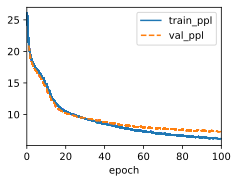

In [21]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [22]:
## Serving - Decoding

In [23]:
def predict(self, prefix, num_preds, vocab, device=None):
    """
    Predict the next words based on a given prefix.

    Args:
        prefix (str): The initial part of the sequence.
        num_preds (int): Number of words to predict.
        vocab (Vocab): The vocabulary object.
        device (torch.device): The device to run the model on. Default is None.

    Returns:
        str: The predicted sequence.
    """
    # Initialize the hidden state and the output list with the first token of the prefix
    state, outputs = None, [vocab[prefix[0]]]
    # Iterate over the range of the length of the prefix plus the number of predictions minus one
    for i in range(len(prefix) + num_preds - 1):
        # Convert the last output to a tensor and move it to the specified device
        X = torch.tensor([[outputs[-1]]], device=device)
        # Convert the input to one-hot encoded format
        embs = self.one_hot(X)
        # Pass the embeddings through the RNN to get the outputs and update the state
        rnn_outputs, state = self.rnn(embs, state)
        # If it's still in the warm-up period, append the next token from the prefix to the outputs
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            # Apply the output layer to the RNN outputs to get the predictions
            Y = self.output_layer(rnn_outputs)
            # Append the index of the predicted token to the outputs
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    # Convert the list of indices to a string using the vocabulary's idx_to_token mapping
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [27]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has and the pather and '

## Concise Implementation of RNN

In [29]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [34]:
class RNN(d2l.Module):  #@save
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        """
        Initialize the RNN model.

        Args:
            num_inputs (int): Number of input features.
            num_hiddens (int): Number of hidden units.
        """
        super().__init__()
        # Save hyperparameters for later use
        self.save_hyperparameters()
        # Create an RNN layer using the high-level API
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        """
        Forward propagation of the RNN model.

        Args:
            inputs (torch.Tensor): Input data with shape (num_steps, batch_size, num_inputs).
            H (torch.Tensor): Initial hidden state with shape (1, batch_size, num_hiddens). Default is None.

        Returns:
            tuple: A tuple containing:
                - outputs (torch.Tensor): Output data with shape (num_steps, batch_size, num_hiddens).
                - H (torch.Tensor): Final hidden state with shape (1, batch_size, num_hiddens).
        """
        # Pass the input data and initial hidden state through the RNN layer
        return self.rnn(inputs, H)
    
class RNNLM(d2l.RNNLMScratch):  #@save
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

In [35]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

/opt/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


'it haszzcq cq cq cq cq cq '

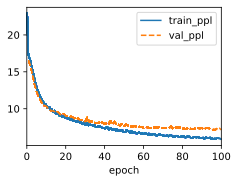

In [36]:
# train it 
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [37]:
model.predict('it has a', 20, data.vocab, d2l.try_gpu())

'it has not the prout in th'